In [1]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd # data frame
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import tqdm as tqdm
import PIL
from PIL import Image, ImageOps
import cv2
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2

# plt.style.use('seaborn')
# sns.set(font_scale=2.5)

import missingno as msno # null data를 보여줌

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def seed_everything(seed):
    """
    동일한 조건으로 학습을 할 때, 동일한 결과를 얻기 위해 seed를 고정시킵니다.
    
    Args:
        seed: seed 정수값
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
seed_everything(42)

In [3]:
df_train = pd.read_csv('input/data/train/train.csv')

## Augmentation

In [4]:
def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    transformations = {}
    if 'train' in need:
        transformations['train'] = A.Compose([
            A.Resize(img_size[0], img_size[1], p=1.0),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.CenterCrop(height=img_size[0]*0.6, width=img_size[1]*0.6),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            A.GaussNoise(p=0.5),
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = A.Compose([
            A.Resize(img_size[0], img_size[1]),
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

## Dataset

In [5]:
class MaskLabels:
    mask = 0
    incorrect = 1
    normal = 2
    
class GenderLabels:
    male = 0
    female = 1
    
class AgeGroup:
    map_label = lambda x: 0 if int(x) < 30 else 1 if int(x) < 58 else 2

In [6]:
class myDataset(Dataset):
    num_classes = 18
    _file_names = {
        "mask1.jpg": MaskLabels.mask,
        "mask2.jpg": MaskLabels.mask,
        "mask3.jpg": MaskLabels.mask,
        "mask4.jpg": MaskLabels.mask,
        "mask5.jpg": MaskLabels.mask,
        "incorrect_mask.jpg": MaskLabels.incorrect,
        "normal.jpg": MaskLabels.normal,
#         "mask1.png": MaskLabels.mask,
#         "mask2.png": MaskLabels.mask,
#         "mask3.png": MaskLabels.mask,
#         "mask4.png": MaskLabels.mask,
#         "mask5.png": MaskLabels.mask,
#         "incorrect_mask.png": MaskLabels.incorrect,
#         "normal.png": MaskLabels.normal,
#         "mask1.jpeg": MaskLabels.mask,
#         "mask2.jpeg": MaskLabels.mask,
#         "mask3.jpeg": MaskLabels.mask,
#         "mask4.jpeg": MaskLabels.mask,
#         "mask5.jpeg": MaskLabels.mask,
#         "incorrect_mask.jpeg": MaskLabels.incorrect,
#         "normal.jpeg": MaskLabels.normal
    }
    
    img_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform
        self.setup()
    
    def set_transform(self, transform):
        self.transform = transform
    
    def setup(self):
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            for file_name, label in self._file_names.items():
                img_path = os.path.join(self.img_dir, profile, file_name)
                if os.path.exists(img_path):
                    self.img_paths.append(img_path)
                    self.mask_labels.append(label)
                    
                    id, gender, race, age = profile.split('_')
                    gender_label = getattr(GenderLabels, gender)
                    age_label = AgeGroup.map_label(age)
                    
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)
                    
    def __getitem__(self, index):
        # load image
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        
        # load label
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label*6 + gender_label*3 + age_label
        
        # image augmentation
        img_transform = self.transform(image=np.array(img))['image']
        return img_transform, multi_class_label
    
    def __len__(self):
        return len(self.img_paths)

In [7]:
# mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
# img_dir = 'input/data/train/images'

# transform = get_transforms(mean=mean, std=std)

# dataset = myDataset(img_dir=img_dir)

# n_val = int(len(dataset) * 0.2)
# n_train = len(dataset) - n_val
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

# train_dataset.dataset.set_transform(transform['train'])
# val_dataset.dataset.set_transform(transform['val'])

In [8]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
img_dir = 'input/data/train/images'

transform = get_transforms(mean=mean, std=std)

dataset = myDataset(img_dir=img_dir)

n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

In [9]:
transform = get_transforms(img_size=(384, 384), mean=mean, std=std)

dataset384 = myDataset(img_dir=img_dir)

n_val = int(len(dataset384) * 0.2)
n_train = len(dataset384) - n_val

train_dataset384, val_dataset384 = torch.utils.data.random_split(dataset384, [n_train, n_val])

train_dataset384.dataset.set_transform(transform['train'])
val_dataset384.dataset.set_transform(transform['val'])

## DataLoader

In [10]:
train_loader = DataLoader(
    train_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=False
)

In [11]:
train_loader384 = DataLoader(
    train_dataset384,
    batch_size=12,
    num_workers=4,
    shuffle=True
)

val_loader384 = DataLoader(
    val_dataset384,
    batch_size=12,
    num_workers=4,
    shuffle=False
)

In [12]:
images, labels = next(iter(train_loader))
print('images shape:', images.shape)
print('labels shape:', labels.shape)

images shape: torch.Size([12, 3, 512, 384])
labels shape: torch.Size([12])


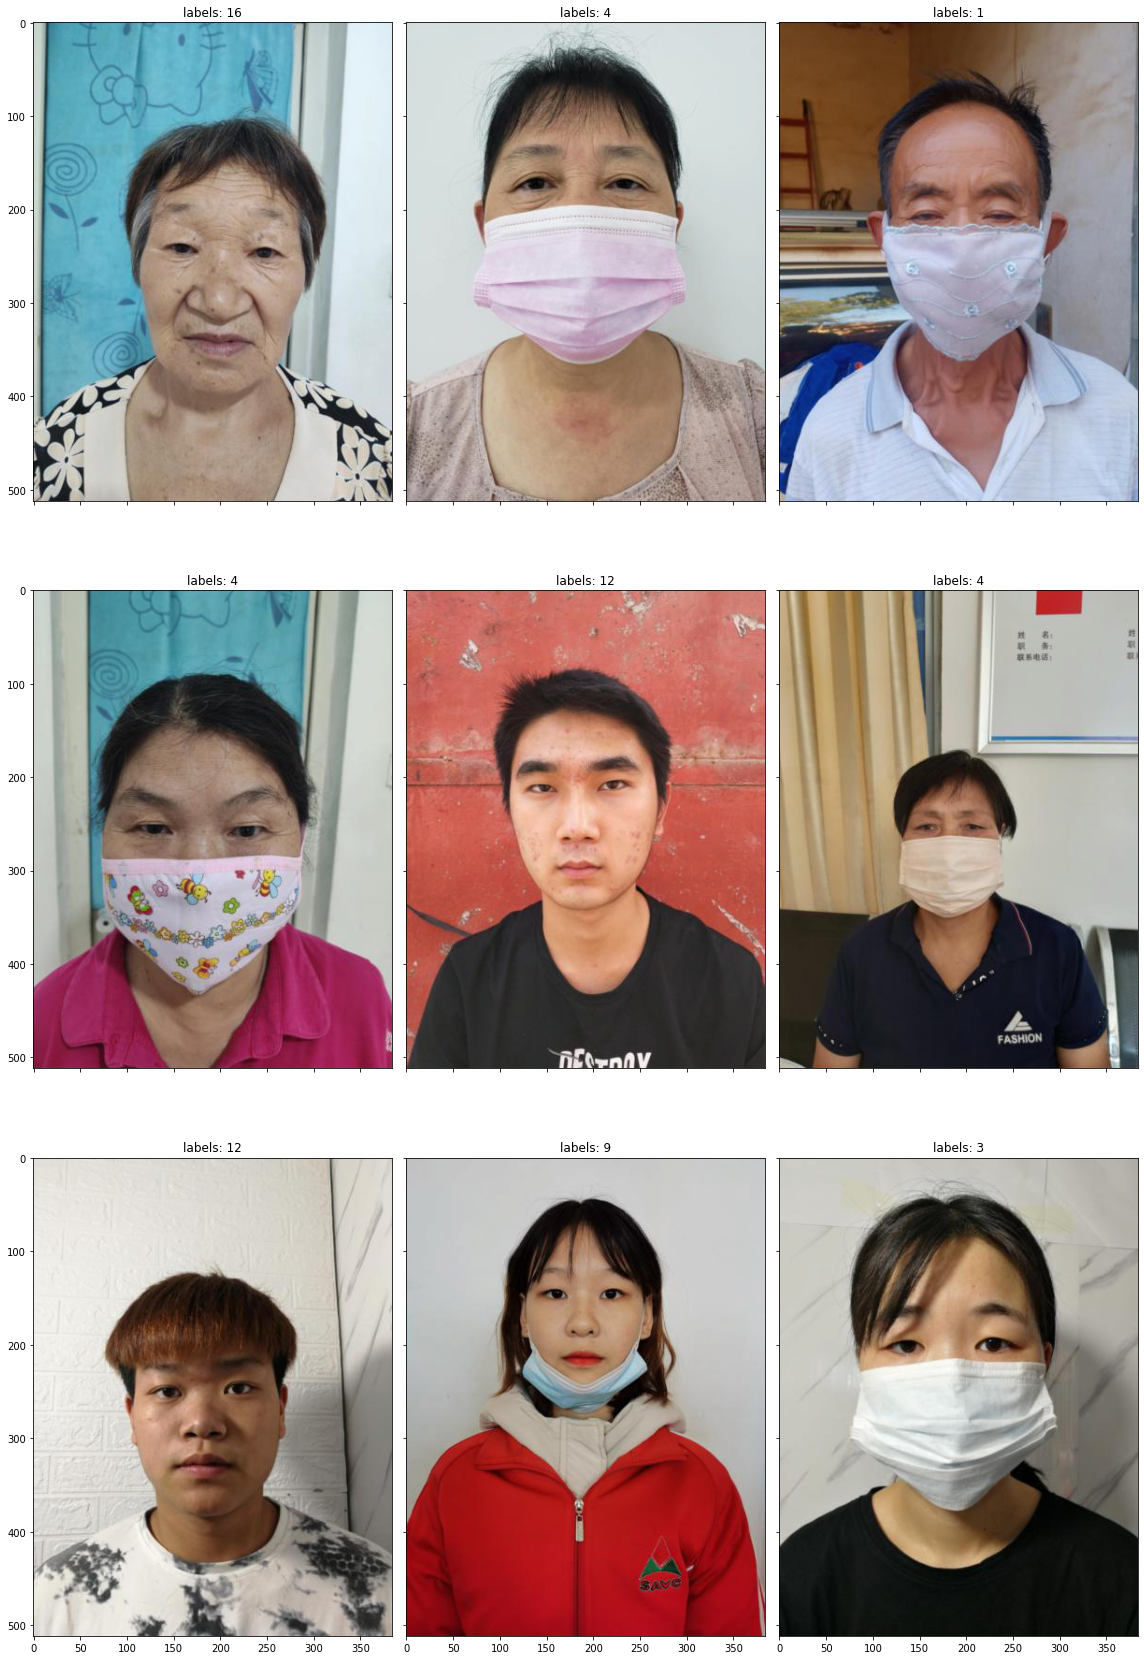

In [13]:
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

f, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16, 24))
idx = 0
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(inv_normalize(images[idx]).permute(1, 2, 0))
        ax[i, j].set_title(f'labels: {labels[idx]}')
        idx += 1
plt.tight_layout()

## Train

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        since = time.time()
        
        # each epoch has step & validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # reapeat
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, dim=-1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
        print()
        
    print(f'Best val Acc: {best_acc}')
    
    model.load_state_dict(best_model_weights)
    return model

## Loss

In [16]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=18, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [18]:
class F1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon
    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

In [19]:
from torch.optim import lr_scheduler
from efficientnet_pytorch import EfficientNet
from adamp import AdamP
import timm
import madgrad

model1 = EfficientNet.from_pretrained('efficientnet-b0', num_classes=18).to(device)
model2 = EfficientNet.from_pretrained('efficientnet-b1', num_classes=18).to(device)
model3 = EfficientNet.from_pretrained('efficientnet-b2', num_classes=18).to(device)
model4 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=18).to(device)
model5 = EfficientNet.from_pretrained('efficientnet-b4', num_classes=18).to(device)

model6 = models.resnet18(pretrained=True)
in_features = model6.fc.in_features
model6.fc = nn.Linear(in_features, 18)
model6.to(device)

model7 = EfficientNet.from_pretrained('efficientnet-b5', num_classes=18).to(device)

model8 = models.resnet50(pretrained=True)
in_features = model8.fc.in_features
model8.fc = nn.Linear(in_features, 18)
model8.to(device)

model9 = timm.create_model('vit_base_resnet50_384', pretrained=True, num_classes=18).to(device)
model10 = timm.create_model('vit_base_patch32_384', pretrained=True, num_classes=18).to(device)

# model = timm.create_model('vit_base_patch32_384', pretrained=True)
# model = model.to(device)

dataloaders = {'train':train_loader, 'val': val_loader}
dataloaders384 = {'train':train_loader384, 'val': val_loader384}

criterion1 = LabelSmoothingLoss()
criterion2 = LabelSmoothingLoss()
criterion3 = LabelSmoothingLoss()
criterion4 = LabelSmoothingLoss()
criterion5 = LabelSmoothingLoss()
criterion6 = LabelSmoothingLoss()
criterion7 = LabelSmoothingLoss()
criterion8 = LabelSmoothingLoss()
criterion9 = LabelSmoothingLoss()
criterion10 = LabelSmoothingLoss()

# optimizer = AdamP(model.parameters(), lr=1e-5)
optimizer1 = optim.Adam(model1.parameters(), lr=5e-4)
optimizer2 = optim.Adam(model2.parameters(), lr=5e-4)
optimizer3 = optim.Adam(model3.parameters(), lr=5e-4)
optimizer4 = optim.Adam(model4.parameters(), lr=5e-4)
optimizer5 = optim.Adam(model5.parameters(), lr=5e-4)
optimizer6 = optim.Adam(model6.parameters(), lr=5e-4)
optimizer7 = optim.Adam(model7.parameters(), lr=5e-4)
optimizer8 = optim.Adam(model8.parameters(), lr=5e-4)
optimizer9 = optim.Adam(model9.parameters(), lr=5e-4)
optimizer10 = optim.Adam(model10.parameters(), lr=5e-4)

exp_lr_scheduler1 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer1, T_0=3)
exp_lr_scheduler2 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer2, T_0=3)
exp_lr_scheduler3 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer3, T_0=3)
exp_lr_scheduler4 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer4, T_0=3)
exp_lr_scheduler5 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer5, T_0=3)
exp_lr_scheduler6 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer6, T_0=3)
exp_lr_scheduler7 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer7, T_0=3)
exp_lr_scheduler8 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer8, T_0=3)
exp_lr_scheduler9 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer9, T_0=3)
exp_lr_scheduler10 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer10, T_0=3)

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b5


In [20]:
model10 = train_model(model10, dataloaders384, criterion10, optimizer10, exp_lr_scheduler10, num_epochs=30)

Epoch 0/29
----------
train Loss: 1.2717 Acc: 0.5583
val Loss: 0.9046 Acc: 0.6679
Training complete in 5.0m 35.50360870361328s

Epoch 1/29
----------
train Loss: 0.5938 Acc: 0.7789
val Loss: 0.5212 Acc: 0.8061
Training complete in 5.0m 36.06059503555298s

Epoch 2/29
----------
train Loss: 0.2159 Acc: 0.9207
val Loss: 0.2525 Acc: 0.9091
Training complete in 5.0m 36.84934329986572s

Epoch 3/29
----------
train Loss: 0.5270 Acc: 0.8066
val Loss: 0.5497 Acc: 0.7979
Training complete in 5.0m 36.58795666694641s

Epoch 4/29
----------
train Loss: 0.3095 Acc: 0.8902
val Loss: 0.3765 Acc: 0.8712
Training complete in 5.0m 35.39809966087341s

Epoch 5/29
----------
train Loss: 0.0812 Acc: 0.9718
val Loss: 0.2010 Acc: 0.9426
Training complete in 5.0m 35.980650424957275s

Epoch 6/29
----------
train Loss: 0.3671 Acc: 0.8679
val Loss: 0.3889 Acc: 0.8643
Training complete in 5.0m 35.95833921432495s

Epoch 7/29
----------
train Loss: 0.1910 Acc: 0.9306
val Loss: 0.2680 Acc: 0.9063
Training complete in 

In [29]:
model9 = train_model(model9, dataloaders384, criterion9, optimizer9, exp_lr_scheduler9, num_epochs=12)

Epoch 0/11
----------
train Loss: 2.5164 Acc: 0.1935
val Loss: 2.5002 Acc: 0.1887
Training complete in 26.0m 29.969547986984253s

Epoch 1/11
----------
train Loss: 2.4891 Acc: 0.1885
val Loss: 2.4996 Acc: 0.1857
Training complete in 26.0m 30.25394320487976s

Epoch 2/11
----------
train Loss: 2.4288 Acc: 0.2188
val Loss: 2.1943 Acc: 0.3126
Training complete in 26.0m 31.400041103363037s

Epoch 3/11
----------
train Loss: 2.4092 Acc: 0.2298
val Loss: 2.1899 Acc: 0.3069
Training complete in 26.0m 31.191349983215332s

Epoch 4/11
----------
train Loss: 2.0725 Acc: 0.3298
val Loss: 1.8596 Acc: 0.3937
Training complete in 26.0m 32.26549983024597s

Epoch 5/11
----------
train Loss: 1.4146 Acc: 0.4995
val Loss: 1.0782 Acc: 0.6214
Training complete in 26.0m 32.609328508377075s

Epoch 6/11
----------
train Loss: 1.0372 Acc: 0.6194
val Loss: 0.8659 Acc: 0.6693
Training complete in 26.0m 33.11400389671326s

Epoch 7/11
----------
train Loss: 0.6900 Acc: 0.7310
val Loss: 0.6004 Acc: 0.7706
Training co

In [21]:
model8 = train_model(model8, dataloaders, criterion8, optimizer8, exp_lr_scheduler8, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.8367 Acc: 0.6925
val Loss: 0.8431 Acc: 0.6670
Training complete in 4.0m 11.864412784576416s

Epoch 1/11
----------
train Loss: 0.4813 Acc: 0.8058
val Loss: 0.3695 Acc: 0.8414
Training complete in 4.0m 11.908776998519897s

Epoch 2/11
----------
train Loss: 0.2740 Acc: 0.8931
val Loss: 0.2730 Acc: 0.8916
Training complete in 4.0m 11.948267698287964s

Epoch 3/11
----------
train Loss: 0.4607 Acc: 0.8192
val Loss: 0.4316 Acc: 0.8181
Training complete in 4.0m 11.983995199203491s

Epoch 4/11
----------
train Loss: 0.2935 Acc: 0.8864
val Loss: 0.4363 Acc: 0.8464
Training complete in 4.0m 11.728814125061035s

Epoch 5/11
----------
train Loss: 0.1263 Acc: 0.9552
val Loss: 0.1412 Acc: 0.9487
Training complete in 4.0m 12.048126697540283s

Epoch 6/11
----------
train Loss: 0.3326 Acc: 0.8751
val Loss: 0.3958 Acc: 0.8689
Training complete in 4.0m 11.77682638168335s

Epoch 7/11
----------
train Loss: 0.1697 Acc: 0.9371
val Loss: 0.2641 Acc: 0.9030
Training complet

In [22]:
model7 = train_model(model7, dataloaders, criterion7, optimizer7, exp_lr_scheduler7, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.5895 Acc: 0.7920
val Loss: 0.2954 Acc: 0.8861
Training complete in 9.0m 51.09864807128906s

Epoch 1/11
----------
train Loss: 0.1970 Acc: 0.9332
val Loss: 0.1537 Acc: 0.9479
Training complete in 9.0m 50.24005055427551s

Epoch 2/11
----------
train Loss: 0.0420 Acc: 0.9876
val Loss: 0.0252 Acc: 0.9911
Training complete in 9.0m 51.4238715171814s

Epoch 3/11
----------
train Loss: 0.2041 Acc: 0.9317
val Loss: 0.1048 Acc: 0.9659
Training complete in 9.0m 51.30278134346008s

Epoch 4/11
----------
train Loss: 0.0603 Acc: 0.9807
val Loss: 0.0688 Acc: 0.9775
Training complete in 9.0m 51.17406368255615s

Epoch 5/11
----------
train Loss: 0.0181 Acc: 0.9948
val Loss: 0.0269 Acc: 0.9903
Training complete in 9.0m 50.3675274848938s

Epoch 6/11
----------
train Loss: 0.1341 Acc: 0.9570
val Loss: 0.2130 Acc: 0.9429
Training complete in 9.0m 50.982872009277344s

Epoch 7/11
----------
train Loss: 0.0407 Acc: 0.9866
val Loss: 0.1218 Acc: 0.9645
Training complete in 9.

In [23]:
model6 = train_model(model6, dataloaders, criterion6, optimizer6, exp_lr_scheduler6, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.6689 Acc: 0.7524
val Loss: 0.4472 Acc: 0.8273
Training complete in 1.0m 49.570884227752686s

Epoch 1/29
----------
train Loss: 0.3454 Acc: 0.8680
val Loss: 0.3222 Acc: 0.8708
Training complete in 1.0m 49.74410939216614s

Epoch 2/29
----------
train Loss: 0.1198 Acc: 0.9604
val Loss: 0.1054 Acc: 0.9590
Training complete in 1.0m 49.36504340171814s

Epoch 3/29
----------
train Loss: 0.3149 Acc: 0.8871
val Loss: 0.4360 Acc: 0.8500
Training complete in 1.0m 49.29383444786072s

Epoch 4/29
----------
train Loss: 0.1300 Acc: 0.9538
val Loss: 0.1501 Acc: 0.9437
Training complete in 1.0m 49.185625076293945s

Epoch 5/29
----------
train Loss: 0.0315 Acc: 0.9912
val Loss: 0.0542 Acc: 0.9800
Training complete in 1.0m 49.38865423202515s

Epoch 6/29
----------
train Loss: 0.2030 Acc: 0.9278
val Loss: 0.1788 Acc: 0.9387
Training complete in 1.0m 49.22103571891785s

Epoch 7/29
----------
train Loss: 0.0666 Acc: 0.9765
val Loss: 0.1713 Acc: 0.9470
Training complete in

In [24]:
model5 = train_model(model5, dataloaders, criterion5, optimizer5, exp_lr_scheduler5, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.5803 Acc: 0.7907
val Loss: 0.3625 Acc: 0.8614
Training complete in 7.0m 18.07248306274414s

Epoch 1/11
----------
train Loss: 0.2001 Acc: 0.9287
val Loss: 0.1508 Acc: 0.9482
Training complete in 7.0m 18.901705741882324s

Epoch 2/11
----------
train Loss: 0.0456 Acc: 0.9859
val Loss: 0.0252 Acc: 0.9909
Training complete in 7.0m 19.027077436447144s

Epoch 3/11
----------
train Loss: 0.1894 Acc: 0.9369
val Loss: 0.1541 Acc: 0.9490
Training complete in 7.0m 18.978538751602173s

Epoch 4/11
----------
train Loss: 0.0744 Acc: 0.9757
val Loss: 0.2310 Acc: 0.9329
Training complete in 7.0m 17.96058177947998s

Epoch 5/11
----------
train Loss: 0.0137 Acc: 0.9962
val Loss: 0.0239 Acc: 0.9925
Training complete in 7.0m 19.864049673080444s

Epoch 6/11
----------
train Loss: 0.1328 Acc: 0.9562
val Loss: 0.1994 Acc: 0.9407
Training complete in 7.0m 18.485236644744873s

Epoch 7/11
----------
train Loss: 0.0450 Acc: 0.9849
val Loss: 0.0922 Acc: 0.9731
Training complete

In [25]:
model4 = train_model(model4, dataloaders, criterion4, optimizer4, exp_lr_scheduler4, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.6038 Acc: 0.7840
val Loss: 0.3431 Acc: 0.8661
Training complete in 5.0m 34.16513276100159s

Epoch 1/11
----------
train Loss: 0.2233 Acc: 0.9206
val Loss: 0.1444 Acc: 0.9473
Training complete in 5.0m 34.30357050895691s

Epoch 2/11
----------
train Loss: 0.0556 Acc: 0.9828
val Loss: 0.0492 Acc: 0.9842
Training complete in 5.0m 34.1316397190094s

Epoch 3/11
----------
train Loss: 0.2083 Acc: 0.9290
val Loss: 0.3432 Acc: 0.8966
Training complete in 5.0m 34.166208267211914s

Epoch 4/11
----------
train Loss: 0.0694 Acc: 0.9771
val Loss: 0.1140 Acc: 0.9640
Training complete in 5.0m 33.033819913864136s

Epoch 5/11
----------
train Loss: 0.0184 Acc: 0.9952
val Loss: 0.0303 Acc: 0.9917
Training complete in 5.0m 33.94393610954285s

Epoch 6/11
----------
train Loss: 0.1436 Acc: 0.9515
val Loss: 0.1527 Acc: 0.9509
Training complete in 5.0m 33.91634511947632s

Epoch 7/11
----------
train Loss: 0.0409 Acc: 0.9862
val Loss: 0.0764 Acc: 0.9775
Training complete in 

In [26]:
model3 = train_model(model3, dataloaders, criterion3, optimizer3, exp_lr_scheduler3, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.5943 Acc: 0.7851
val Loss: 0.2710 Acc: 0.9027
Training complete in 4.0m 29.41183567047119s

Epoch 1/11
----------
train Loss: 0.2225 Acc: 0.9202
val Loss: 0.2460 Acc: 0.9099
Training complete in 4.0m 30.37396764755249s

Epoch 2/11
----------
train Loss: 0.0573 Acc: 0.9829
val Loss: 0.0444 Acc: 0.9842
Training complete in 4.0m 30.109744787216187s

Epoch 3/11
----------
train Loss: 0.1983 Acc: 0.9307
val Loss: 0.1529 Acc: 0.9498
Training complete in 4.0m 29.591506481170654s

Epoch 4/11
----------
train Loss: 0.0689 Acc: 0.9779
val Loss: 0.0480 Acc: 0.9853
Training complete in 4.0m 29.592276096343994s

Epoch 5/11
----------
train Loss: 0.0180 Acc: 0.9951
val Loss: 0.0216 Acc: 0.9914
Training complete in 4.0m 29.27446413040161s

Epoch 6/11
----------
train Loss: 0.1315 Acc: 0.9536
val Loss: 0.1275 Acc: 0.9537
Training complete in 4.0m 29.75181555747986s

Epoch 7/11
----------
train Loss: 0.0399 Acc: 0.9876
val Loss: 0.0529 Acc: 0.9839
Training complete i

In [27]:
model2 = train_model(model2, dataloaders, criterion2, optimizer2, exp_lr_scheduler2, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.5971 Acc: 0.7832
val Loss: 0.2927 Acc: 0.8836
Training complete in 4.0m 20.89893388748169s

Epoch 1/11
----------
train Loss: 0.2301 Acc: 0.9143
val Loss: 0.2026 Acc: 0.9238
Training complete in 4.0m 21.091473817825317s

Epoch 2/11
----------
train Loss: 0.0676 Acc: 0.9787
val Loss: 0.0402 Acc: 0.9867
Training complete in 4.0m 20.953751802444458s

Epoch 3/11
----------
train Loss: 0.1889 Acc: 0.9346
val Loss: 0.1739 Acc: 0.9387
Training complete in 4.0m 21.172590255737305s

Epoch 4/11
----------
train Loss: 0.0666 Acc: 0.9786
val Loss: 0.1097 Acc: 0.9670
Training complete in 4.0m 21.424859762191772s

Epoch 5/11
----------
train Loss: 0.0215 Acc: 0.9942
val Loss: 0.0325 Acc: 0.9906
Training complete in 4.0m 21.989879608154297s

Epoch 6/11
----------
train Loss: 0.1248 Acc: 0.9574
val Loss: 0.1123 Acc: 0.9667
Training complete in 4.0m 21.495880603790283s

Epoch 7/11
----------
train Loss: 0.0408 Acc: 0.9872
val Loss: 0.0911 Acc: 0.9709
Training complet

In [28]:
model1 = train_model(model1, dataloaders, criterion1, optimizer1, exp_lr_scheduler1, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.5897 Acc: 0.7871
val Loss: 0.2597 Acc: 0.8994
Training complete in 3.0m 4.996014356613159s

Epoch 1/11
----------
train Loss: 0.2296 Acc: 0.9193
val Loss: 0.1599 Acc: 0.9421
Training complete in 3.0m 5.3323540687561035s

Epoch 2/11
----------
train Loss: 0.0674 Acc: 0.9791
val Loss: 0.0408 Acc: 0.9859
Training complete in 3.0m 4.978956699371338s

Epoch 3/11
----------
train Loss: 0.1856 Acc: 0.9351
val Loss: 0.1825 Acc: 0.9263
Training complete in 3.0m 4.900376081466675s

Epoch 4/11
----------
train Loss: 0.0752 Acc: 0.9737
val Loss: 0.0682 Acc: 0.9795
Training complete in 3.0m 5.187632322311401s

Epoch 5/11
----------
train Loss: 0.0197 Acc: 0.9948
val Loss: 0.0278 Acc: 0.9920
Training complete in 3.0m 5.047031402587891s

Epoch 6/11
----------
train Loss: 0.1312 Acc: 0.9563
val Loss: 0.2033 Acc: 0.9351
Training complete in 3.0m 5.322848320007324s

Epoch 7/11
----------
train Loss: 0.0425 Acc: 0.9856
val Loss: 0.0545 Acc: 0.9817
Training complete in 

## Visualize

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    f = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=-1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds[j]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model)

## Test

In [30]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [31]:
test_dir = '/opt/ml/input/data/eval'

In [ ]:
from torchvision.transforms import Resize, ToTensor, Normalize
import tqdm as tqdm

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

transform384 = transforms.Compose([
    Resize((384, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

test_dataset = TestDataset(image_paths, transform)
test_dataset384 = TestDataset(image_paths, transform)

test_loader = DataLoader(
    test_dataset,
    shuffle=False
)

test_loader384 = DataLoader(
    test_dataset384,
    shuffle=False
)

oof_pred = None
M = {
    'model1': model1, 'model2': model2, 'model3': model3, 
    'model4': model4, 'model5': model5, 'model6': model6,
    'model7': model7, 'model8': model8
    }

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.

for i in (range(1, 9)):
    all_predictions = []
    with torch.no_grad():
        
        for images in test_loader:
            images = images.to(device)

            # Test Time Augmentation
            pred = M[f'model{i}'](images) # 원본 이미지를 예측하고
            all_predictions.extend(pred.cpu().numpy())
                
        fold_pred = np.array(all_predictions)
        
        print('='*20)
        print(fold_pred)
        print('='*20)
        
    if oof_pred is None:
        oof_pred = fold_pred / 5
    else:
        oof_pred = oof_pred + (fold_pred / 5)

[[ -0.73825246   3.0971158    7.150343   ...   2.4701135    3.7241635
    4.3910856 ]
 [ -2.5247958    2.4290547   13.228688   ...  -4.584269    -7.932935
   -3.2622986 ]
 [ -0.58021253  -3.1293936    8.810529   ...   2.9728343    1.4025865
   10.066175  ]
 ...
 [ -8.305665   -10.459512   -13.748982   ...   1.6496036   -3.6180491
  -14.908404  ]
 [  0.1413818    8.732736     9.021811   ...  -9.956203   -12.763438
  -11.2515335 ]
 [ -7.305336     1.6172656   -2.415811   ... -20.084497   -14.16723
  -15.772342  ]]
[[ -0.3794753   -2.0140634    9.080162   ...   4.192731     3.613966
    4.1172795 ]
 [  0.09842926   4.7017055   11.791871   ...  -4.77464     -9.442535
   -8.602237  ]
 [  0.5334138    1.1970274    1.5309231  ...   5.176612     6.927138
    7.879737  ]
 ...
 [-18.343248    -8.357424    -4.661949   ...   1.2179885  -10.174231
  -17.059013  ]
 [  1.3349571   10.515777     2.9645252  ...  -6.4465327   -8.570984
  -12.738877  ]
 [ -2.6613865   -0.8862108    5.763689   ... -10.588

In [ ]:
submission['ans'] = np.argmax(oof_pred, axis=1)
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

## Hyperparameter log

In [ ]:
# import neptune

# ns = neptune.init(project_qualified_name=f'ssun-g/pstage1', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDkzZTAxOS02NTM3LTRmZTMtODZhMi0wY2JkYzFiYzE3MDMifQ==')

# neptune.create_experiment('onlyjpg_efficientnet_Adam_FocalLoss_CosineAnnealingLR')

# neptune.log_metric('learning_rate', 0.0003)
# neptune.log_metric('weight_decay', 5e-4)
# neptune.log_metric('num_epochs', 15)
# neptune.log_metric('scheduler_T_max', 2)
# neptune.log_metric('batch_size', 12)
# neptune.log_metric('num_workers', 4)

In [ ]:
from IPython.display import Audio
Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg", autoplay=True)

In [ ]:
from torchvision.transforms import Resize, ToTensor, Normalize
import tqdm as tqdm

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

transform384 = transforms.Compose([
    Resize((384, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

test_dataset = TestDataset(image_paths, transform)
test_dataset384 = TestDataset(image_paths, transform)

test_loader = DataLoader(
    test_dataset,
    shuffle=False
)

test_loader384 = DataLoader(
    test_dataset384,
    shuffle=False
)

oof_pred = None
M = {
    'model1': model1, 'model2': model2, 'model3': model3, 
    'model4': model4, 'model5': model5, 'model6': model6,
    'model7': model7, 'model8': model8
    }

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.

for i in (range(1, 9)):
    all_predictions = []
    with torch.no_grad():
        
        for images in test_loader:
            images = images.to(device)

            # Test Time Augmentation
            pred = M[f'model{i}'](images) # 원본 이미지를 예측하고
            all_predictions.extend(pred.cpu().numpy())
                
        fold_pred = np.array(all_predictions)
        
        print('='*20)
        print(fold_pred)
        print('='*20)
        
    if oof_pred is None:
        oof_pred = fold_pred / 8
    else:
        oof_pred = oof_pred + (fold_pred / 8)

In [ ]:
submission['ans'] = np.argmax(oof_pred, axis=1)
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')